## ICU AS RESPONSE VARIABLE

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import categorical_embedder as ce
import tensorflow as tf
import keras_tuner
import scikitplot as skplt

from xgboost import XGBClassifier
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTEN
from tensorflow.keras import layers
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import svm
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors, datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [2]:
# file directory
os.chdir('OneDrive/Documents/AA UM/SQB7002/')

In [3]:
# reading file
df = pd.read_csv('DatasetForPublication.csv')
df.head()

,id,sex,agecat,ethnicity3cat,imd,bmicat,diabetes1,diabetes2,hypertension,cvd,asthma,copd,cancer,renaldisease,icu,died30days,timeatrisk
0,1,Female,70-79,White,IMD 1,Overweight,No,Yes,Yes,Yes,No,Yes,No,No,No,No,6
1,2,Male,60-69,White,IMD 1,Overweight,No,Yes,No,No,No,No,No,No,No,No,17
2,3,Male,70-79,White,IMD 1,Healthy weight,No,Yes,Yes,Yes,Yes,No,No,No,No,No,8
3,4,Male,80+,White,IMD 4/5,Healthy weight,No,No,No,Yes,No,No,No,No,No,Yes,13
4,5,Male,60-69,White,IMD 3,Healthy weight,No,No,No,No,No,No,No,No,No,No,7


DATA PREPROCESSING

In [4]:
# drop ID, died30days, timeatrisk, ethnicity and response (icu)
df3 = df.drop(["id", "icu", "died30days", "timeatrisk"], axis = 1)
print(df3.head())
print(df3.shape)

      sex agecat ethnicity3cat      imd          bmicat diabetes1 diabetes2  \
0  Female  70-79         White    IMD 1      Overweight        No       Yes   
1    Male  60-69         White    IMD 1      Overweight        No       Yes   
2    Male  70-79         White    IMD 1  Healthy weight        No       Yes   
3    Male    80+         White  IMD 4/5  Healthy weight        No        No   
4    Male  60-69         White    IMD 3  Healthy weight        No        No   

  hypertension  cvd asthma copd cancer renaldisease  
0          Yes  Yes     No  Yes     No           No  
1           No   No     No   No     No           No  
2          Yes  Yes    Yes   No     No           No  
3           No  Yes     No   No     No           No  
4           No   No     No   No     No           No  
(582, 13)


In [5]:
# convert dataframe into arrays
X = df3

# icu as response variable
y = df["icu"]
label_encoder = preprocessing.LabelEncoder()
y = y.to_numpy()
y = label_encoder.fit_transform(y)

df_X1 = X.drop(["sex", "ethnicity3cat"], axis=1)
df_X2 = X[["sex", "ethnicity3cat"]]

X_coded, encoders = ce.get_label_encoded_data(df_X1)
X_onehot = pd.get_dummies(df_X2)
X_encoded = pd.concat([X_coded, X_onehot], axis=1)

# splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y,
                                                   test_size = 0.1, random_state = 100)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# calling SMOTE function
smote_nc = SMOTEN(random_state=0)
# oversampling
X_train, y_train = smote_nc.fit_resample(X_train, y_train)

In [6]:
X_train.shape

(940, 16)

## MODEL KNN

In [7]:
def test_params(**params):
    model = KNeighborsClassifier(**params).fit(X_train, y_train)
    return model.score(X_test, y_test)
for par in range(1,10):
    parameter = test_params(n_neighbors = par)
    print('The Test Accuracy for n_neighbors {} is:'.format(par), parameter)

The Test Accuracy for n_neighbors 1 is: 0.9322033898305084
The Test Accuracy for n_neighbors 2 is: 0.9322033898305084
The Test Accuracy for n_neighbors 3 is: 0.9322033898305084
The Test Accuracy for n_neighbors 4 is: 0.8135593220338984
The Test Accuracy for n_neighbors 5 is: 0.7796610169491526
The Test Accuracy for n_neighbors 6 is: 0.7796610169491526
The Test Accuracy for n_neighbors 7 is: 0.7457627118644068
The Test Accuracy for n_neighbors 8 is: 0.7966101694915254
The Test Accuracy for n_neighbors 9 is: 0.6949152542372882


0.93
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        55
           1       0.50      0.25      0.33         4

    accuracy                           0.93        59
   macro avg       0.72      0.62      0.65        59
weighted avg       0.92      0.93      0.92        59

[[54  1]
 [ 3  1]]


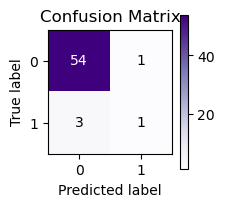

In [8]:
model_knn = KNeighborsClassifier(n_neighbors = 2)

# Train the model using the training sets
model_knn.fit(X_train,y_train)
y_pred = model_knn.predict(X_test)
print(round(accuracy_score(y_test, y_pred), 2))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test, y_pred,
                                    normalize=False,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax = ax
                                    );

No Skill Model: ROC AUC=0.500
k-NN: ROC AUC=0.827


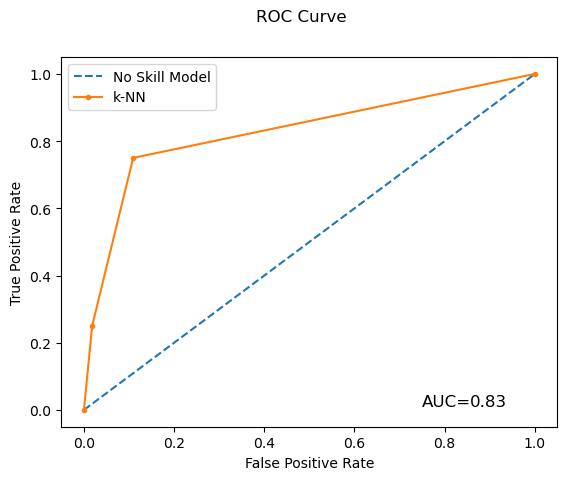

In [9]:
# predict probabilities
ns_probs = [0 for _ in range(len(y_test))]
knn_prob = model_knn.predict_proba(X_test)
# keep probabilities for the positive outcome only
knn_prob = knn_prob[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
knn_auc = roc_auc_score(y_test, knn_prob)
# summarize scores
print('No Skill Model: ROC AUC=%.3f' % (ns_auc))
print('k-NN: ROC AUC=%.3f' % (knn_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_prob)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill Model')
pyplot.plot(knn_fpr, knn_tpr, marker='.', label='k-NN')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.suptitle('ROC Curve')
pyplot.text(0.855, 0.01, round(knn_auc,2), fontsize = 12)
pyplot.text(0.75, 0.01, "AUC=", fontsize = 12)
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## MODEL SVM

0.83
              precision    recall  f1-score   support

           0       0.96      0.85      0.90        55
           1       0.20      0.50      0.29         4

    accuracy                           0.83        59
   macro avg       0.58      0.68      0.59        59
weighted avg       0.91      0.83      0.86        59

[[47  8]
 [ 2  2]]


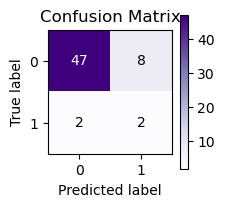

In [10]:
model_svm = svm.SVC(kernel = "rbf", probability = True)
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)
print(round(accuracy_score(y_test, y_pred), 2))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test, y_pred,
                                    normalize=False,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax = ax
                                    );

No Skill Model: ROC AUC=0.500
SVM: ROC AUC=0.827


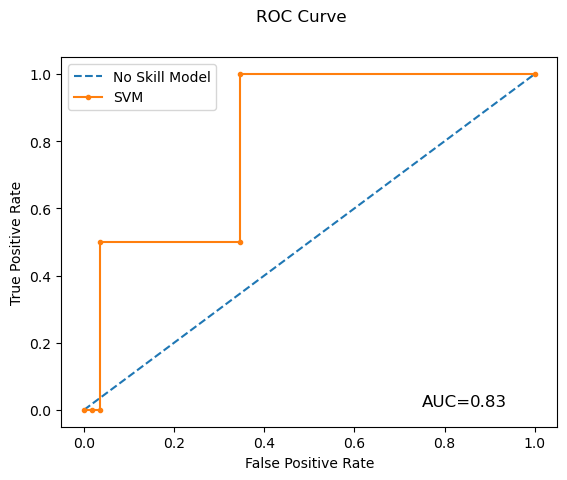

In [11]:
# predict probabilities
ns_probs = [0 for _ in range(len(y_test))]
svm_prob = model_svm.predict_proba(X_test)
# keep probabilities for the positive outcome only
svm_prob = svm_prob[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
svm_auc = roc_auc_score(y_test, knn_prob)
# summarize scores
print('No Skill Model: ROC AUC=%.3f' % (ns_auc))
print('SVM: ROC AUC=%.3f' % (svm_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_prob)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill Model')
pyplot.plot(svm_fpr, svm_tpr, marker='.', label='SVM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.suptitle('ROC Curve')
pyplot.text(0.855, 0.01, round(svm_auc,2), fontsize = 12)
pyplot.text(0.75, 0.01, "AUC=", fontsize = 12)
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## MODEL LOGISTIC REGRESSION

0.8
              precision    recall  f1-score   support

           0       0.96      0.82      0.88        55
           1       0.17      0.50      0.25         4

    accuracy                           0.80        59
   macro avg       0.56      0.66      0.57        59
weighted avg       0.90      0.80      0.84        59

[[45 10]
 [ 2  2]]


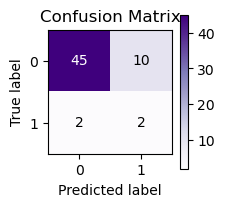

In [12]:
model_lr = LogisticRegression(random_state = 42)

# fit the model with data
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)
print(round(accuracy_score(y_test, y_pred), 2))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test, y_pred,
                                    normalize=False,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax = ax
                                    );

No Skill Model: ROC AUC=0.500
Logistic: ROC AUC=0.677


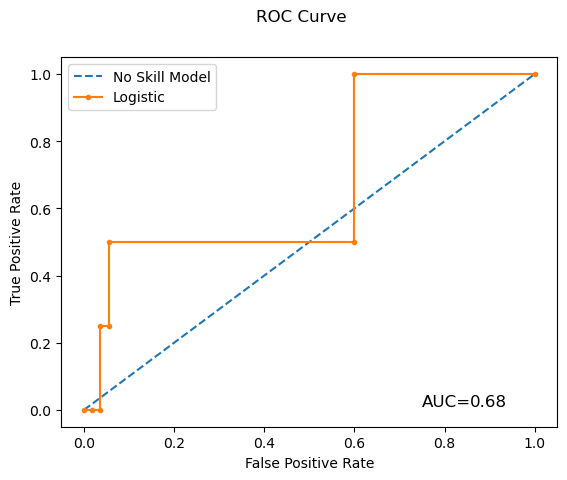

In [13]:
# predict probabilities
ns_probs = [0 for _ in range(len(y_test))]
lr_prob = model_lr.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_prob = lr_prob[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_prob)
# summarize scores
print('No Skill Model: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_prob)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill Model')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.suptitle('ROC Curve')
pyplot.text(0.855, 0.01, round(lr_auc,2), fontsize = 12)
pyplot.text(0.75, 0.01, "AUC=", fontsize = 12)
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## MODEL DECISION TREE

In [14]:
for max_d in range(1,16):
    model = tree.DecisionTreeClassifier(max_depth = max_d, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('The Training Accuracy for max_depth {} is:'.format(max_d), accuracy_score(y_test, y_pred))

The Training Accuracy for max_depth 1 is: 0.6271186440677966
The Training Accuracy for max_depth 2 is: 0.7796610169491526
The Training Accuracy for max_depth 3 is: 0.8305084745762712
The Training Accuracy for max_depth 4 is: 0.8135593220338984
The Training Accuracy for max_depth 5 is: 0.847457627118644
The Training Accuracy for max_depth 6 is: 0.8813559322033898
The Training Accuracy for max_depth 7 is: 0.847457627118644
The Training Accuracy for max_depth 8 is: 0.847457627118644
The Training Accuracy for max_depth 9 is: 0.8813559322033898
The Training Accuracy for max_depth 10 is: 0.8983050847457628
The Training Accuracy for max_depth 11 is: 0.8813559322033898
The Training Accuracy for max_depth 12 is: 0.8983050847457628
The Training Accuracy for max_depth 13 is: 0.8983050847457628
The Training Accuracy for max_depth 14 is: 0.8983050847457628
The Training Accuracy for max_depth 15 is: 0.8983050847457628


0.88
              precision    recall  f1-score   support

           0       0.98      0.89      0.93        55
           1       0.33      0.75      0.46         4

    accuracy                           0.88        59
   macro avg       0.66      0.82      0.70        59
weighted avg       0.94      0.88      0.90        59

[[49  6]
 [ 1  3]]


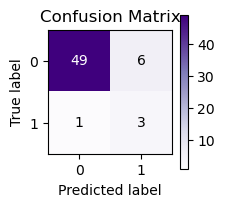

In [15]:
dt = tree.DecisionTreeClassifier(max_depth = 9, random_state=42)
model_dt = dt.fit(X_train, y_train)
y_pred = model_dt.predict(X_test)
print(round(accuracy_score(y_test, y_pred), 2))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test, y_pred,
                                    normalize=False,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax = ax
                                    );

Text(0.6627072704081632, 0.95, 'X[0] <= 2.5\ngini = 0.5\nsamples = 940\nvalue = [470, 470]')

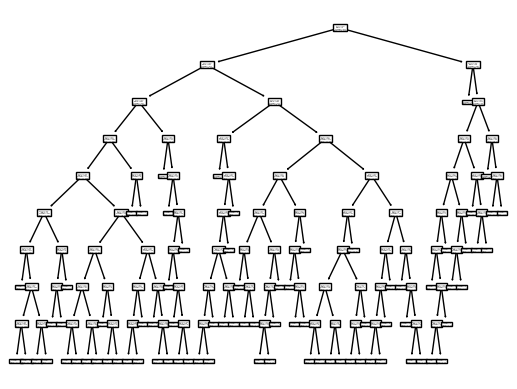

In [16]:
tree.plot_tree(model_dt)[0]

No Skill Model: ROC AUC=0.500
Decision Tree: ROC AUC=0.818


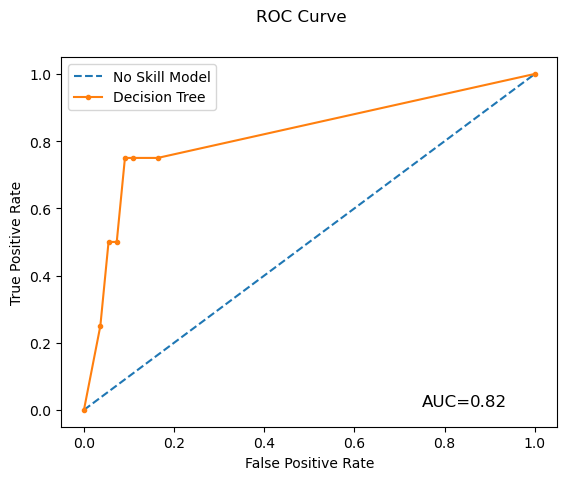

In [17]:
# predict probabilities
ns_probs = [0 for _ in range(len(y_test))]
dt_prob = model_dt.predict_proba(X_test)
# keep probabilities for the positive outcome only
dt_prob = dt_prob[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
dt_auc = roc_auc_score(y_test, dt_prob)
# summarize scores
print('No Skill Model: ROC AUC=%.3f' % (ns_auc))
print('Decision Tree: ROC AUC=%.3f' % (dt_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_prob)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill Model')
pyplot.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.suptitle('ROC Curve')
pyplot.text(0.855, 0.01, round(dt_auc,2), fontsize = 12)
pyplot.text(0.75, 0.01, "AUC=", fontsize = 12)
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## MODEL RANDOM FOREST

In [18]:
def test_params(**params):
    model = RandomForestClassifier(random_state = 42, n_jobs = -1, **params).fit(X_train, y_train)
    return model.score(X_test, y_test)
for par in range(1,16):
    parameter = test_params(n_estimators = par)
    print('The Test Accuracy for n_estimator {} is:'.format(par), parameter)

The Test Accuracy for n_estimator 1 is: 0.864406779661017
The Test Accuracy for n_estimator 2 is: 0.9152542372881356
The Test Accuracy for n_estimator 3 is: 0.9152542372881356
The Test Accuracy for n_estimator 4 is: 0.9152542372881356
The Test Accuracy for n_estimator 5 is: 0.9152542372881356
The Test Accuracy for n_estimator 6 is: 0.9152542372881356
The Test Accuracy for n_estimator 7 is: 0.9152542372881356
The Test Accuracy for n_estimator 8 is: 0.9152542372881356
The Test Accuracy for n_estimator 9 is: 0.9152542372881356
The Test Accuracy for n_estimator 10 is: 0.9152542372881356
The Test Accuracy for n_estimator 11 is: 0.9152542372881356
The Test Accuracy for n_estimator 12 is: 0.9152542372881356
The Test Accuracy for n_estimator 13 is: 0.9152542372881356
The Test Accuracy for n_estimator 14 is: 0.9152542372881356
The Test Accuracy for n_estimator 15 is: 0.9152542372881356


In [19]:
for par in ["auto","log2","sqrt", None]:
    parameter = test_params(max_features = par)
    print('The Test Accuracy for max_features {} is:'.format(par), parameter)

The Test Accuracy for max_features auto is: 0.9152542372881356
The Test Accuracy for max_features log2 is: 0.9152542372881356
The Test Accuracy for max_features sqrt is: 0.9152542372881356
The Test Accuracy for max_features None is: 0.9322033898305084


In [20]:
for par in range(2,11):
    parameter = test_params(min_samples_split = par)
    print('The Test Accuracy for min_samples_split {} is:'.format(par), parameter)

The Test Accuracy for min_samples_split 2 is: 0.9152542372881356
The Test Accuracy for min_samples_split 3 is: 0.9152542372881356
The Test Accuracy for min_samples_split 4 is: 0.9152542372881356
The Test Accuracy for min_samples_split 5 is: 0.9152542372881356
The Test Accuracy for min_samples_split 6 is: 0.9152542372881356
The Test Accuracy for min_samples_split 7 is: 0.9152542372881356
The Test Accuracy for min_samples_split 8 is: 0.9152542372881356
The Test Accuracy for min_samples_split 9 is: 0.9322033898305084
The Test Accuracy for min_samples_split 10 is: 0.9322033898305084


0.92
              precision    recall  f1-score   support

           0       0.96      0.95      0.95        55
           1       0.40      0.50      0.44         4

    accuracy                           0.92        59
   macro avg       0.68      0.72      0.70        59
weighted avg       0.92      0.92      0.92        59

[[52  3]
 [ 2  2]]


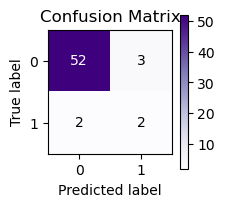

In [21]:
rf = RandomForestClassifier(random_state = 42, n_jobs = -1, n_estimators = 7, min_samples_split=2, max_features = "auto")
model_rf = rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
print(round(accuracy_score(y_test, y_pred), 2))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test, y_pred,
                                    normalize=False,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax = ax
                                    );

No Skill Model: ROC AUC=0.500
Random Forest: ROC AUC=0.893


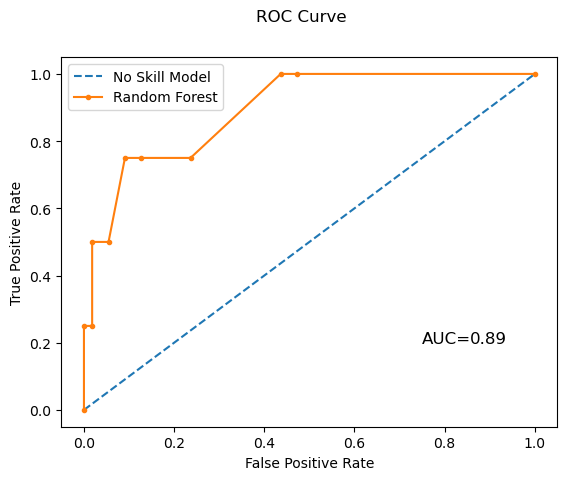

In [22]:
ns_probs = [0 for _ in range(len(y_test))]
rf_prob = model_rf.predict_proba(X_test)
# keep probabilities for the positive outcome only
rf_prob = rf_prob[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
rf_auc = roc_auc_score(y_test, rf_prob)
# summarize scores
print('No Skill Model: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill Model')
pyplot.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.suptitle('ROC Curve')
pyplot.text(0.855, 0.20, round(rf_auc,2), fontsize = 12)
pyplot.text(0.75, 0.20, "AUC=", fontsize = 12)
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## MODEL BAGGING

In [23]:
def test_params(**params):
    model = BaggingClassifier(random_state = 42, **params).fit(X_train, y_train)
    return model.score(X_test, y_test)

for par in range(1,11):
    parameter = test_params(n_estimators = par)
    print('The Test Accuracy for n_estimator {} is:'.format(par), parameter)

The Test Accuracy for n_estimator 1 is: 0.8135593220338984
The Test Accuracy for n_estimator 2 is: 0.864406779661017
The Test Accuracy for n_estimator 3 is: 0.8813559322033898
The Test Accuracy for n_estimator 4 is: 0.9322033898305084
The Test Accuracy for n_estimator 5 is: 0.9322033898305084
The Test Accuracy for n_estimator 6 is: 0.9322033898305084
The Test Accuracy for n_estimator 7 is: 0.9322033898305084
The Test Accuracy for n_estimator 8 is: 0.9322033898305084
The Test Accuracy for n_estimator 9 is: 0.9322033898305084
The Test Accuracy for n_estimator 10 is: 0.9322033898305084


0.93
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        55
           1       0.50      0.75      0.60         4

    accuracy                           0.93        59
   macro avg       0.74      0.85      0.78        59
weighted avg       0.95      0.93      0.94        59

[[52  3]
 [ 1  3]]


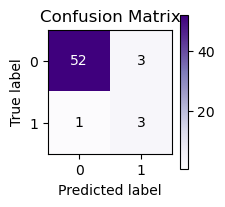

In [24]:
model_bag = BaggingClassifier(n_estimators = 8, random_state = 42)

# Fit the model
model_bag.fit(X_train, y_train)
y_pred = model_bag.predict(X_test)
print(round(accuracy_score(y_test, y_pred), 2))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test, y_pred,
                                    normalize=False,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax = ax
                                    );

No Skill Model: ROC AUC=0.500
Bagging: ROC AUC=0.891


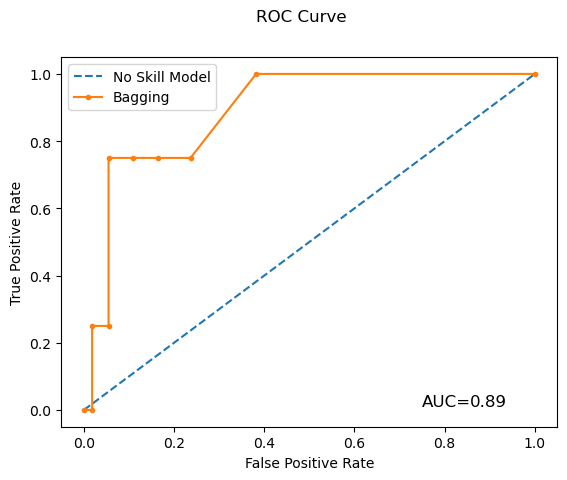

In [25]:
ns_probs = [0 for _ in range(len(y_test))]
bag_prob = model_bag.predict_proba(X_test)
# keep probabilities for the positive outcome only
bag_prob = bag_prob[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
bag_auc = roc_auc_score(y_test, bag_prob)
# summarize scores
print('No Skill Model: ROC AUC=%.3f' % (ns_auc))
print('Bagging: ROC AUC=%.3f' % (bag_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
bag_fpr, bag_tpr, _ = roc_curve(y_test, bag_prob)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill Model')
pyplot.plot(bag_fpr, bag_tpr, marker='.', label='Bagging')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.suptitle('ROC Curve')
pyplot.text(0.855, 0.01, round(bag_auc,2), fontsize = 12)
pyplot.text(0.75, 0.01, "AUC=", fontsize = 12)
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## MODEL XGBOOST

In [26]:
def test_params(**params):
    model = XGBClassifier(random_state = 42, **params).fit(X_train, y_train)
    return model.score(X_test, y_test)

for par in np.arange(0.35, 0.45, 0.01):
    parameter = round(test_params(eta = par),4)
    print('The Test Accuracy for eta {} is:'.format(round(par,2)), parameter)

The Test Accuracy for eta 0.35 is: 0.8983
The Test Accuracy for eta 0.36 is: 0.9153
The Test Accuracy for eta 0.37 is: 0.8983
The Test Accuracy for eta 0.38 is: 0.8814
The Test Accuracy for eta 0.39 is: 0.9153
The Test Accuracy for eta 0.4 is: 0.9322
The Test Accuracy for eta 0.41 is: 0.8983
The Test Accuracy for eta 0.42 is: 0.8983
The Test Accuracy for eta 0.43 is: 0.8814
The Test Accuracy for eta 0.44 is: 0.8983
The Test Accuracy for eta 0.45 is: 0.8983


In [27]:
for par in range(1, 10, 5):
    parameter = test_params(gamma = par)
    print('The Test Accuracy for gamma {} is:'.format(par), parameter)

The Test Accuracy for gamma 1 is: 0.9152542372881356
The Test Accuracy for gamma 6 is: 0.9152542372881356


0.93
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        55
           1       0.50      0.50      0.50         4

    accuracy                           0.93        59
   macro avg       0.73      0.73      0.73        59
weighted avg       0.93      0.93      0.93        59

[[53  2]
 [ 2  2]]


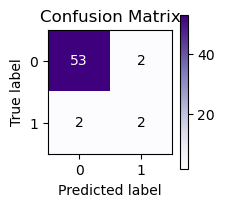

In [28]:
model_xgb = XGBClassifier(eta = 0.4, random_state = 42)

# Fit the model
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
print(round(accuracy_score(y_test, y_pred), 2))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test, y_pred,
                                    normalize=False,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax = ax
                                    );

In [29]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

No Skill Model: ROC AUC=0.500
XGBoost: ROC AUC=0.886


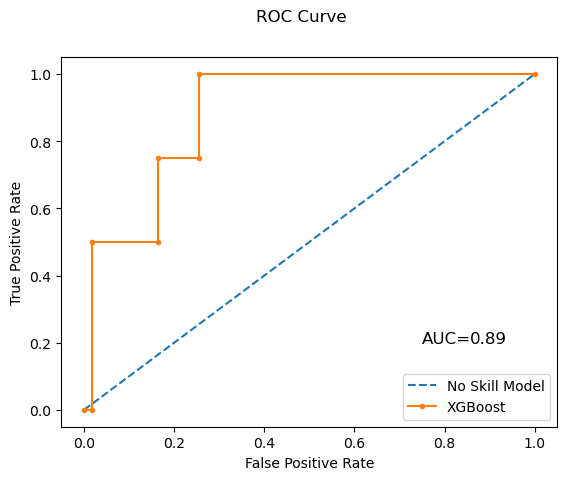

In [30]:
ns_probs = [0 for _ in range(len(y_test))]
xgb_prob = model_xgb.predict_proba(X_test)
# keep probabilities for the positive outcome only
xgb_prob = xgb_prob[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
xgb_auc = roc_auc_score(y_test, xgb_prob)
# summarize scores
print('No Skill Model: ROC AUC=%.3f' % (ns_auc))
print('XGBoost: ROC AUC=%.3f' % (xgb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_prob)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill Model')
pyplot.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.suptitle('ROC Curve')
pyplot.text(0.855, 0.2, round(xgb_auc,2), fontsize = 12)
pyplot.text(0.75, 0.2, "AUC=", fontsize = 12)
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## MODEL ANN

In [31]:
# convert dataframe into arrays
X = df3

# icu as response variable
y = df["icu"]
label_encoder = preprocessing.LabelEncoder()
y = y.to_numpy()
y = label_encoder.fit_transform(y)

X_onehot = pd.get_dummies(X)
X_encoded = pd.concat([X_onehot], axis=1)

# splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y,
                                                   test_size = 0.1, random_state = 100)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
# calling SMOTE function
smote_nc = SMOTEN(random_state=0)
# oversampling
X_train, y_train = smote_nc.fit_resample(X_train, y_train)

In [32]:
X_train.shape

(940, 33)

In [33]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units = hp.Int('units_' + str(i),
                                             min_value = 32,
                                             max_value = 512,
                                             step = 32),
                              activation = 'relu'))
        model.add(layers.Dense(1, activation = 'sigmoid'))
        model.compile(optimizer = keras.optimizers.Adam(hp.Choice('learning_rate',
                                                                 [1e-2, 1e-3, 1e-4])),
                     loss = 'binary_crossentropy',
                     metrics = ['accuracy'])
        return model
    
tuner = RandomSearch(build_model,
                    objective = 'accuracy',
                    max_trials = 5,
                    executions_per_trial = 3)
tuner.search(X_train, y_train,
            epochs = 100,
            validation_data = (X_test, y_test))
tuner.results_summary()

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit
Results summary
Results in .\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 3
units_0: 416
learning_rate: 0.01
Score: 0.8496453960736593
Trial summary
Hyperparameters:
num_layers: 4
units_0: 384
learning_rate: 0.01
Score: 0.8485815326372782
Trial summary
Hyperparameters:
num_layers: 6
units_0: 416
learning_rate: 0.01
Score: 0.8482269247372946
Trial summary
Hyperparameters:
num_layers: 8
units_0: 224
learning_rate: 0.001
Score: 0.8439716299374899
Trial summary
Hyperparameters:
num_layers: 5
units_0: 288
learning_rate: 0.0001
Score: 0.8031914830207825


In [34]:
#Initialising ANN
ann = tf.keras.models.Sequential()

#Adding First Hidden Layer
ann.add(tf.keras.layers.Dense(units=416,activation="relu"))

#Adding Second Hidden Layer
ann.add(tf.keras.layers.Dense(units=416,activation="relu"))

#Adding Third Hidden Layer
ann.add(tf.keras.layers.Dense(units=416,activation="relu"))

#Adding Output Layer
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

#Compiling ANN
ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss="binary_crossentropy",metrics=['accuracy'])

#Fitting ANN
ann.fit(X_train, y_train,batch_size=100,epochs = 100)

Epoch 1/100
10/10 [==============================] - 1s 8ms/step - loss: 1.3594 - accuracy: 0.6447
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 0.3399 - accuracy: 0.8798
Epoch 3/100
10/10 [==============================] - 0s 9ms/step - loss: 0.2113 - accuracy: 0.9309
Epoch 4/100
10/10 [==============================] - 0s 8ms/step - loss: 0.1872 - accuracy: 0.9319
Epoch 5/100
10/10 [==============================] - 0s 9ms/step - loss: 0.1643 - accuracy: 0.9404
Epoch 6/100
10/10 [==============================] - 0s 8ms/step - loss: 0.1493 - accuracy: 0.9404
Epoch 7/100
10/10 [==============================] - 0s 8ms/step - loss: 0.1533 - accuracy: 0.9436
Epoch 8/100
10/10 [==============================] - 0s 7ms/step - loss: 0.1534 - accuracy: 0.9426
Epoch 9/100
10/10 [==============================] - 0s 8ms/step - loss: 0.1300 - accuracy: 0.9511
Epoch 10/100
10/10 [==============================] - 0s 8ms/step - loss: 0.1097 - accuracy: 0.9543
Epoch 11/

Epoch 83/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0765 - accuracy: 0.9713
Epoch 84/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0733 - accuracy: 0.9702
Epoch 85/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0489 - accuracy: 0.9809
Epoch 86/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0434 - accuracy: 0.9798
Epoch 87/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0439 - accuracy: 0.9787
Epoch 88/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0614 - accuracy: 0.9809
Epoch 89/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0556 - accuracy: 0.9766
Epoch 90/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0431 - accuracy: 0.9787
Epoch 91/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0435 - accuracy: 0.9787
Epoch 92/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0420 - accuracy: 0.9840


2/2 [==============================] - 0s 4ms/step
0.93
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        55
           1       0.50      0.75      0.60         4

    accuracy                           0.93        59
   macro avg       0.74      0.85      0.78        59
weighted avg       0.95      0.93      0.94        59

[[52  3]
 [ 1  3]]


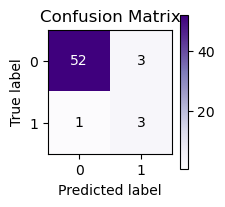

In [35]:
# accuracy using test data
y_pred = (ann.predict(X_test) > 0.5).astype("int32")
print(round(accuracy_score(y_test, y_pred), 2))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test, y_pred,
                                    normalize=False,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax = ax
                                    );

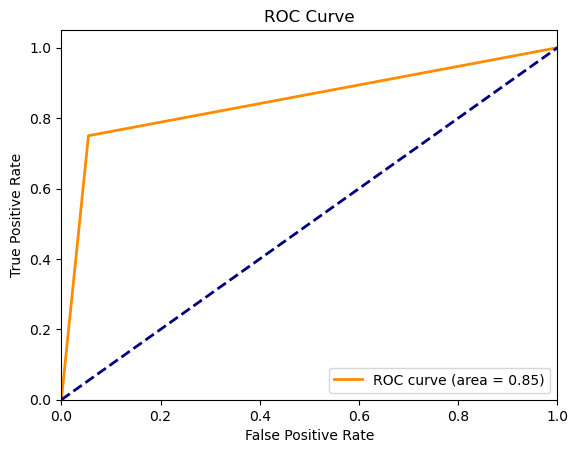

In [36]:
def plot_roc_auc(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
plot_roc_auc(y_test, y_pred)

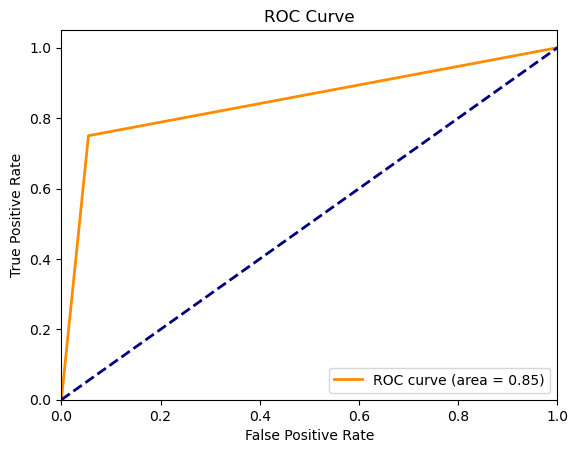

In [37]:
plot_roc_auc(y_test, y_pred)

2/2 [==============================] - 0s 4ms/step
No Skill Model: ROC AUC=0.500
k-NN: ROC AUC=0.868


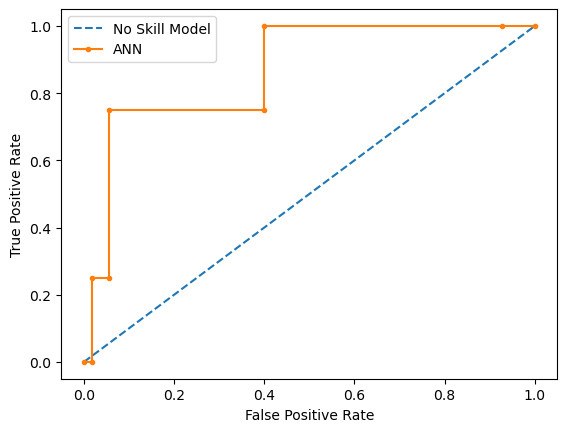

In [38]:
# predict probabilities
ns_probs = [0 for _ in range(len(y_test))]
ann_prob = ann.predict(X_test)
# keep probabilities for the positive outcome only
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
ann_auc = roc_auc_score(y_test, ann_prob)
# summarize scores
print('No Skill Model: ROC AUC=%.3f' % (ns_auc))
print('k-NN: ROC AUC=%.3f' % (ann_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
ann_fpr, ann_tpr, _ = roc_curve(y_test, ann_prob)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill Model')
pyplot.plot(ann_fpr, ann_tpr, marker='.', label='ANN')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()